# CSCE 636: Deep Learning
# UIN: 828002068
# Name: Mamoon Masud
# Submission - 8 
# Architecture - Transfer Learning ( Inception-v1 Inflated 3D ConvNet )
# Activity Recognition Project - Prediction Code

In [2]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
import keras_video.utils
import tensorflow
from tensorflow.keras import backend
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import (Conv2D, MaxPooling3D, Conv3D,MaxPooling2D)
from tensorflow.keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from collections import deque
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import os.path
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading the Saved Model Weights

In [3]:
# Set the path to the saved location of the JSON file. 
base_path = 'Enter Path where model and weight files are located'
model_path = os.path.join(base_path,'sub_8_model.json' )
with open(model_path, 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model = tensorflow.keras.models.model_from_json(json_savedModel)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
i3d_inception (Model)        (None, 1, 1, 1, 1024)     12294544  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1, 1024)     0         
_________________________________________________________________
Conv3d_6a_1x1 (Conv3D)       (None, 1, 1, 1, 200)      205000    
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
# Load the saved model weight
weight_path = os.path.join(base_path, 'sub_8_weights.hdf5')
model.load_weights(weight_path)

In [ ]:
optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(optimizer=optimizer , 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Testing the model on new data


In [5]:
# Function for predictions

In [6]:
def predict_door(input_file, output_file, image_path):
    img_rows, img_cols, img_depth = 224, 224, 15
    x_train = [] #Variable for storing the files 
    ## Code for extracting 15 frames (distanced at equal interval in the video) from Door Training set
    t_hold = 0.501 #threshold for class prediction
    vid_p = input_file
    interval_duration = 7 # This defines the seconds after which we make a prediction
    frames = []
    legend = []
    cap = cv2.VideoCapture(vid_p)
    fps = cap.get(5) # Getting the frames per second. 
    total_frames = int(cap.get(7))  #Total frames in the video
    vid_dur = int(total_frames/fps) # Gives the video duration in seconds
    intervals = int(vid_dur/interval_duration) #This defines how many predictions we'll make
    if intervals == 0:
        intervals = 1
    frame_per_interval = total_frames //intervals #This defines how many frames are in total for each prediction duration (7 secs)
    frame_distance = frame_per_interval//img_depth #This defines the no. of frames we'll skip.

    frame_count = 0 # This variable keeps count of the total frames, and is reset after extracting each frame
    save_frame = 0 
    interval_count = 1
    
    # Parameters for the plot.
    fig = plt.figure(figsize = (10,10), dpi = 200)
    plt.xlabel("Time (secs)")
    plt.ylabel("label")
    
    for i in range (total_frames): #iterating over all the frames of the video.
            ret, frame = cap.read()
            if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
                frame = f_prev
            elif ret==True:
                f_prev =frame
            frame_count +=1
            if frame_count ==(frame_distance):
                frame_count = 0
                frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
                frames.append(frame)

            if i == ((interval_count*frame_per_interval)-1):
                inpt = np.array(frames)
                inpt = inpt.astype('float32')
                inpt -= np.mean(inpt)
                inpt /=np.max(inpt)
                
                frames = []
                mod_in = np.zeros((1, 15, 224, 224, 3))
                mod_in[0][:][:][:][:] = inpt[:15][:][:][:]
                p = model.predict(mod_in, batch_size = 1)#verbose = 1)
                prob = p[:][0][0]
                s0 = (interval_count-1)*interval_duration #Starting time of the interval in secs
                s1 = (interval_count)*interval_duration   # Ending time of the interval in secs
                print(p)
                if prob >= t_hold:
                    s2 = [('Door: ' +  str(s0) + 'secs - ' + str(s1) + 'secs.')]
                    s3 = 'door'
                    s4 = [s3,s3,s3,s3,s3,s3,s3]
                else:
                    s2 = [('Not_Door: ' +  str(s0) + 'secs - ' + str(s1) + 'secs.')]
                    s3 = 'Not Door'
                    s4 = [s3,s3,s3,s3,s3,s3,s3]
                plot_interval = range((interval_count-1)*7 , (interval_count*7))
                plt.plot(plot_interval, s4, 'o', linestyle='--', color = 'blue')  
                plt.fill_between(plot_interval,(s3), color = 'gray')
                
                print(interval_count)
                interval_count += 1 #Incrementing interval count by 1
                print(s3)
                legend.append(s2)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()
    print(legend)
    with open(output_file, 'w') as f:
        f.write(str(legend))
    plot_title= 'Predicted Labels for Video File'
    plt.title(plot_title)
    plt.savefig(image_path)

[[0.9808195  0.01918051]]
1
door
[['Door: 0secs - 7secs.']]


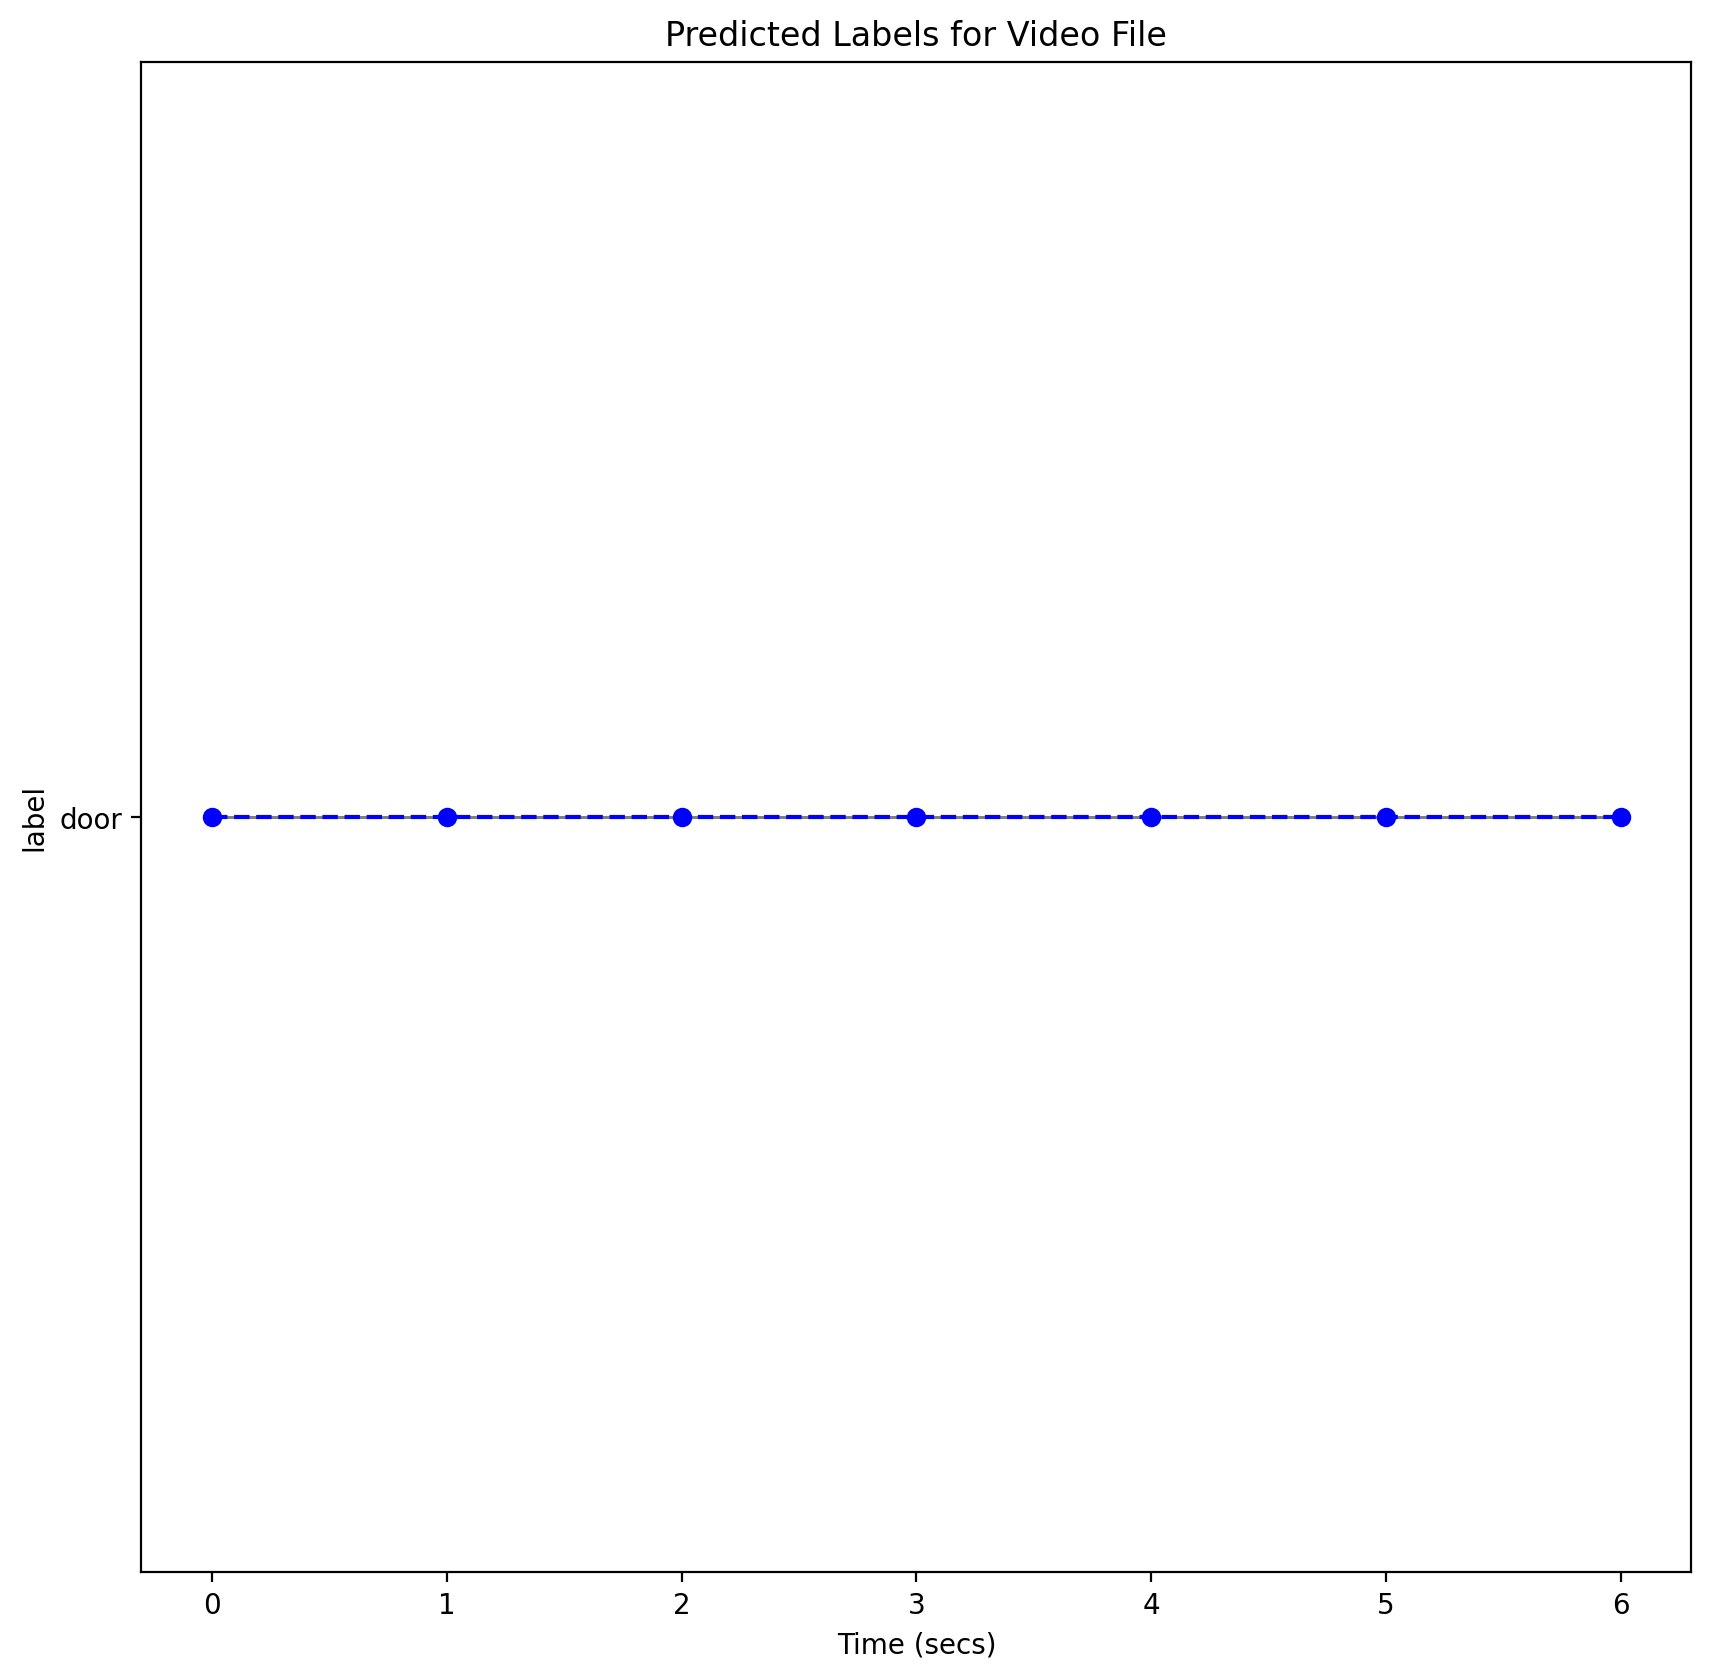

In [19]:
base_path = 'enter path of the video' 
video_file = 'video name'
v_name = video_file+ '.mp4'
json_name =  video_file+ '.json'
img_name = video_file + '.jpeg'

in_1 = os.path.join(base_path, v_name)  # Input the path of the video
out_2 = os.path.join(base_path, json_name) #Input the path of the JSON File 
img_path = os.path.join(base_path, img_name)
predict_door(in_1 , out_2, img_path)